In [2]:
import matplotlib.pyplot as plt
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, LayerNormalization
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPool2D, MaxPool1D
from tensorflow.keras.callbacks import TensorBoard
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import time

import pickle
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [3]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [4]:
TEST_PROPORTION = 0.3
N_BACS = 16
N_FEATURES = 241
DATASTORE = 'D:\\TCC\\Datasets\\preprocess_bac_new'
PICKLES_PATH = os.path.join(DATASTORE, 'pickles')
LABELS = []
def load_img_data(path, filename='masked.pickle'):
    bacs = []
    dirs = os.listdir(path)
    count = 0
    for i in dirs:
        count += 1
        LABELS.append(i)
        dirpath = os.path.join(path, i)
        files = os.listdir(dirpath)
        for j in files:
            if j == filename:
                pickle_in = open(os.path.join(dirpath, j), "rb")
                bacs.append(pickle.load(pickle_in))
    return bacs

def get_layer(hsi, layer):
    return hsi[:, :, layer]

def show_img_on_wave(cube, layer):
    mat = get_layer(cube, layer)
    plt.imshow(mat, cmap='gray')
    plt.show()


def hsi2mat(arr):
    if len(arr.shape) != 3:
        raise BaseException('A entrada deve possuir 3 dimensões')

    r, c, w = arr.shape
    return np.reshape(arr, (r*c, w))


def mat2hsi(mat, shape):
    return np.reshape(mat, shape)

def remove_blank_lines(bacs):
    new_bacs = []
    for i in bacs:
        bac = hsi2mat(i)
        new_bac = bac[~np.all(bac == 0, axis=1)]
        new_bacs.append(new_bac)
    return new_bacs

def create_ylabels(bacs):
    dataset = []
    for ind, val in enumerate(bacs):
        dataset.append([val, ind])
    return dataset

def concat_lines_on_datasets(x,y, bac, cl: int):
    if (x.shape[0] > 0):
      x = np.concatenate((x, bac))
    else:
      x = bac

    y = np.append(y, [cl]*len(bac))
    return (x, y)

def create_one_hot_encoding(dataset, features):
  y = np.zeros((dataset.shape[0], features))
  for i in range(len(dataset)):
    y[i,int(dataset[i])] = 1
  return y

def shuffle_dataset(x, y):
    seed = np.random.randint(0, 1000*1000)
    np.random.seed(seed)
    np.random.shuffle(x)
    np.random.seed(seed)
    np.random.shuffle(y)
    return (x,y)

def split_xy(dataset):
    x = np.array([])
    y = np.array([])
    for f, l in dataset:
        x,y = concat_lines_on_datasets(x, y, f, l)
    return (x,create_one_hot_encoding(y, len(dataset)))


def load_dataset(path):
    bacs = load_img_data(path)
    nozeros = remove_blank_lines(bacs)
    return create_ylabels(nozeros)


def normalize(data):
    return tf.keras.utils.normalize(data, 1)

def save_pickle(data, name):
    pickle_out = open(os.path.join(PICKLES_PATH, name), "wb")
    pickle.dump(data, pickle_out)

    pickle_out.close()
    
def load_pickle(filename):
    picklein = open(os.path.join(PICKLES_PATH, filename), "rb")
    return pickle.load(picklein)


In [24]:
# execution
def train_cnn(model,x,y, epochs=25):
    model.fit(x,y, epochs=epochs, batch_size=32,validation_split=0.3, verbose=1)
    return model


def test_cnn(cnn_model):
    bacs = load_dataset(os.path.join(DATASTORE, 'Test'))
    xtest, ytest = split_xy(bacs)
    nx_test = normalize(xtest)
    nx_test = nx_test.reshape((nx_test.shape[0], nx_test.shape[1], 1))

    cnn_model.evaluate(nx_test, ytest, batch_size=32)
    ypred = cnn_model.predict(nx_test, batch_size=32, verbose=1)
    labels = tf.argmax(ytest, axis=1)

    return (labels, tf.argmax(ypred, axis=1))

def cmatrix(labels, predict):
    cm = confusion_matrix(labels, predict)
    cmp = ConfusionMatrixDisplay(cm, np.arange(N_BACS))

    fig, ax = plt.subplots(figsize=(20, 20))
    cmp.plot(ax=ax, values_format='d')

def class_report(labels, predict):
    classfic = classification_report(labels, predict, np.arange(N_BACS), LABELS)
    print(classfic)

    
def train_rna(model):
    bacs = load_dataset(os.path.join(DATASTORE, 'Train'))
    xtrain, ytrain = split_xy(bacs)
    xtrain, ytrain = shuffle_dataset(xtrain, ytrain)
    nx_train = normalize(xtrain)
    nx_train = nx_train.reshape((nx_train.shape[0], nx_train.shape[1], 1))

    model.fit(nx_train, ytrain, epochs=15, batch_size=32,
                validation_split=0.3, verbose=1)

    return model


def test_rna(mlp_model):
    bacs = load_dataset(os.path.join(DATASTORE, 'Test'))
    xtest, ytest = split_xy(bacs)
    nx_test = normalize(xtest)
    nx_test = nx_test.reshape((nx_test.shape[0], nx_test.shape[1], 1))

    mlp_model.evaluate(nx_test, ytest, batch_size=32)
    ypred = mlp_model.predict(nx_test, batch_size=32, verbose=1)
    labels = tf.argmax(ytest, axis=1)

    return (labels, tf.argmax(ypred, axis=1))


In [28]:
bacs = load_dataset(os.path.join(DATASTORE, 'Train'))
xtrain, ytrain = split_xy(bacs)
# xtrain, ytrain = shuffle_dataset(xtrain, ytrain)
nx_train = normalize(xtrain)
nx_train = nx_train.reshape((nx_train.shape[0], nx_train.shape[1], 1))


In [30]:
bacs[0]
print(ytrain[0:50,:])

AttributeError: 'list' object has no attribute 'shape'

In [27]:
model = Sequential([
    Conv1D(filters=64, kernel_size=3, strides=2, activation='relu',
           input_shape=(N_FEATURES, 1)),
    MaxPool1D(pool_size=3, strides=2),
    LayerNormalization(),
    Conv1D(filters=64, kernel_size=2, activation='relu'),
    MaxPool1D(pool_size=3, strides=2),
    LayerNormalization(),
    Conv1D(filters=64, kernel_size=2, padding="VALID", activation='relu'),
    MaxPool1D(pool_size=3),
    LayerNormalization(),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(rate=0.5),
    Dense(N_BACS, activation='relu')
])

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
# model.summary()
# cnn_model = train_cnn(model, nx_train, ytrain)


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [26]:
labels, predict = test_cnn(cnn_model)

29311/29311 [==============================] - 39s 1ms/step


C:\Users\Vinicius Moraes\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass display_labels=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


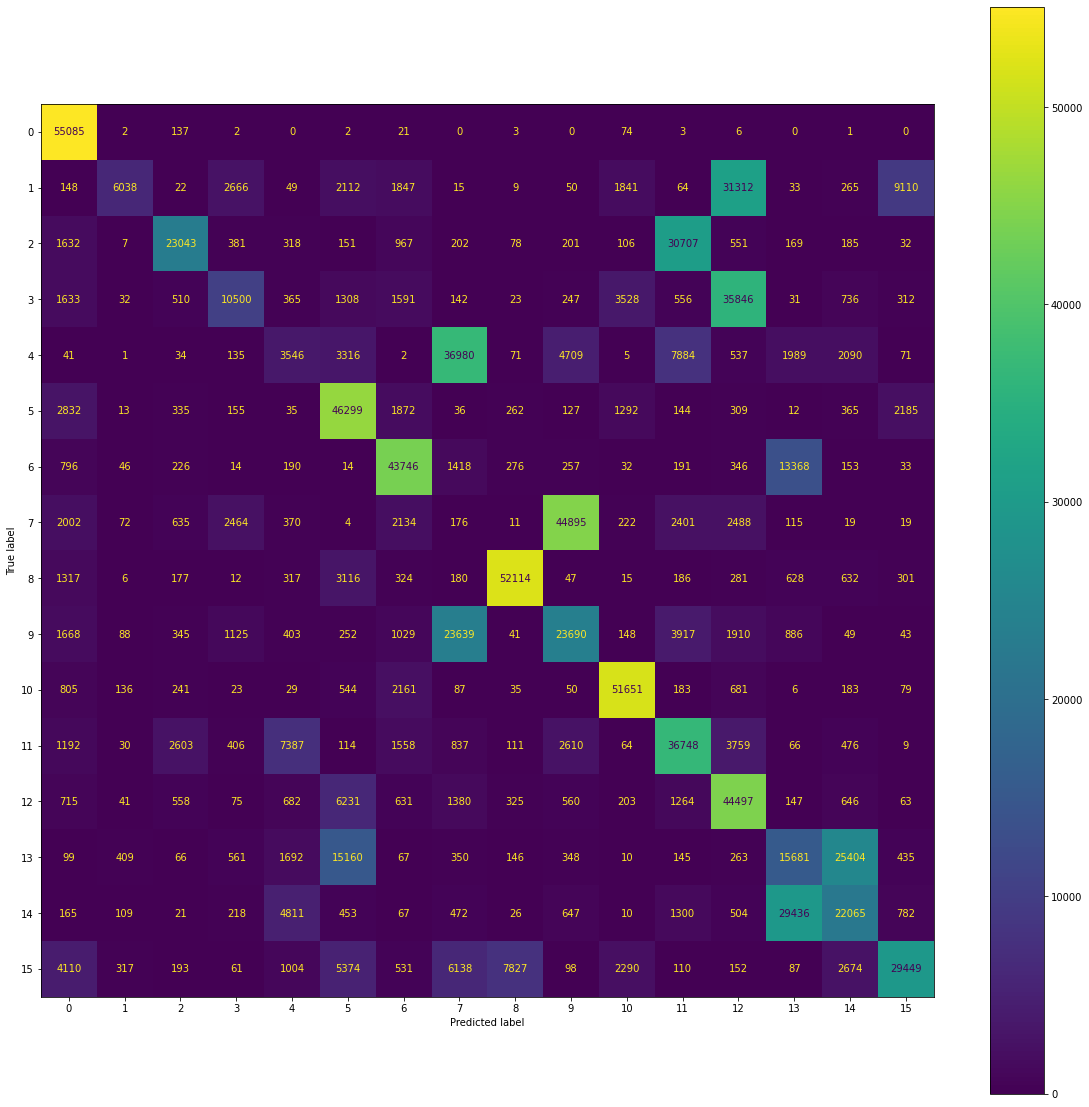

In [30]:
cmatrix(labels, predict)

In [33]:
class_report(labels, predict)


C:\Users\Vinicius Moraes\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15], target_names=['Bacillusscereus_14579_Plastico_B_180926-092335', 'Bacillussubtilis_6633_Plastico_B_180926-092656', 'Coryniumbacteriumglutaminum_13032_Plastico_B_180926-093210', 'Enterobacteaerogenes_13048_Plastico_B_Contaminado_180926-102747', 'Enterobactercloacal_HMFFTA_Plastico_B_180926-103027', 'Enterococcusfaecalis_29212_Plastico_B_180926-093958', 'Escherichiacoli_25922_Plastico_B_180926-102054', 'Klebsielapneumonial_700603_Plastico_B_180926-105913', 'Micrococcusluteus_9341_Plastico_B_180926-093534', 'Proteusmirabilis_9433_Plastico_B_180926-103336', 'Pseudomonasaeoruginosas_9027_Plastico_B_180926-104046', 'Salmonellaspp_10708_Plastico_B_180926-104803', 'Serratiamarcences_14765_Plastico_B_180926-105123', 'Staphylococcusaureus_25923_Plastico_B_Contaminado_180926-101712', 'Staphylococcusaureus_653

                                                                 precision    recall  f1-score   support

                 Bacillusscereus_14579_Plastico_B_180926-092335       0.74      1.00      0.85     55336
                 Bacillussubtilis_6633_Plastico_B_180926-092656       0.82      0.11      0.19     55581
     Coryniumbacteriumglutaminum_13032_Plastico_B_180926-093210       0.79      0.39      0.52     58730
Enterobacteaerogenes_13048_Plastico_B_Contaminado_180926-102747       0.56      0.18      0.28     57360
            Enterobactercloacal_HMFFTA_Plastico_B_180926-103027       0.17      0.06      0.09     61411
            Enterococcusfaecalis_29212_Plastico_B_180926-093958       0.55      0.82      0.66     56273
                 Escherichiacoli_25922_Plastico_B_180926-102054       0.75      0.72      0.73     61106
            Klebsielapneumonial_700603_Plastico_B_180926-105913       0.00      0.00      0.00     58027
                Micrococcusluteus_9341_Plastico_B_1809

In [35]:
mlp_model = Sequential([
    Flatten(),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(N_BACS, activation='softmax')
])

mlp_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

mlp_model = train_rna(mlp_model)

Epoch 1/15
8771/8771 [==============================] - 31s 3ms/step - loss: 1.5009 - accuracy: 0.5733 - val_loss: 0.9265 - val_accuracy: 0.7380
Epoch 2/15
8771/8771 [==============================] - 30s 3ms/step - loss: 0.8186 - accuracy: 0.7532 - val_loss: 0.7040 - val_accuracy: 0.7844
Epoch 3/15
8771/8771 [==============================] - 30s 3ms/step - loss: 0.6719 - accuracy: 0.7884 - val_loss: 0.6140 - val_accuracy: 0.8142
Epoch 4/15
8771/8771 [==============================] - 31s 3ms/step - loss: 0.5927 - accuracy: 0.8095 - val_loss: 0.5599 - val_accuracy: 0.8281
Epoch 5/15
8771/8771 [==============================] - 31s 3ms/step - loss: 0.5460 - accuracy: 0.8210 - val_loss: 0.5413 - val_accuracy: 0.8215
Epoch 6/15
8771/8771 [==============================] - 31s 3ms/step - loss: 0.5113 - accuracy: 0.8303 - val_loss: 0.5052 - val_accuracy: 0.8170
Epoch 7/15
8771/8771 [==============================] - 31s 3ms/step - loss: 0.4873 - accuracy: 0.8365 - val_loss: 0.7322 - val_ac

In [36]:
mlp_labs, mlp_pred = test_rna(mlp_model)

29311/29311 [==============================] - 23s 779us/step


C:\Users\Vinicius Moraes\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass display_labels=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


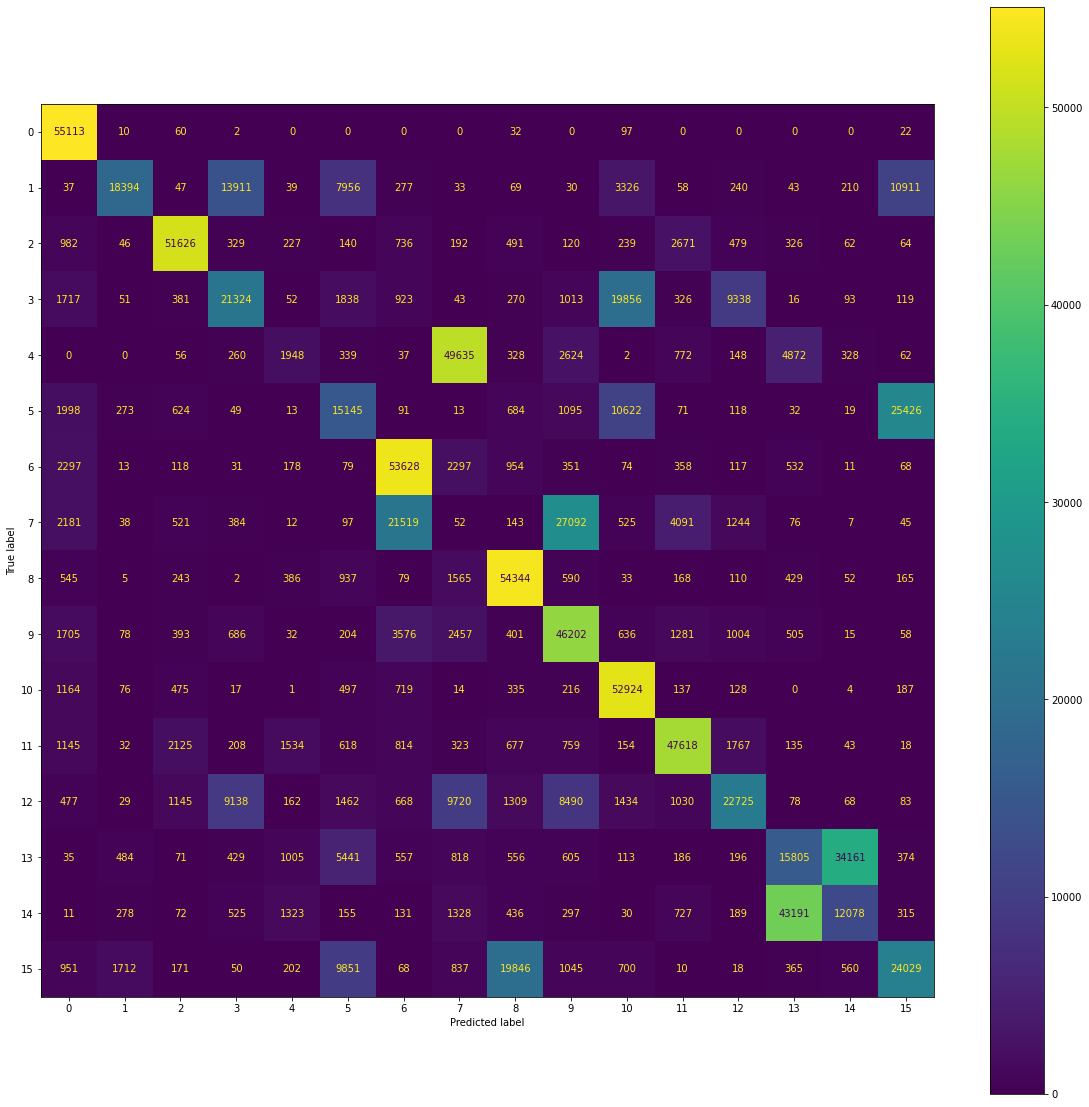

In [37]:
cmatrix(mlp_labs, mlp_pred)

In [38]:
class_report(mlp_labs, mlp_pred)

C:\Users\Vinicius Moraes\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15], target_names=['Bacillusscereus_14579_Plastico_B_180926-092335', 'Bacillussubtilis_6633_Plastico_B_180926-092656', 'Coryniumbacteriumglutaminum_13032_Plastico_B_180926-093210', 'Enterobacteaerogenes_13048_Plastico_B_Contaminado_180926-102747', 'Enterobactercloacal_HMFFTA_Plastico_B_180926-103027', 'Enterococcusfaecalis_29212_Plastico_B_180926-093958', 'Escherichiacoli_25922_Plastico_B_180926-102054', 'Klebsielapneumonial_700603_Plastico_B_180926-105913', 'Micrococcusluteus_9341_Plastico_B_180926-093534', 'Proteusmirabilis_9433_Plastico_B_180926-103336', 'Pseudomonasaeoruginosas_9027_Plastico_B_180926-104046', 'Salmonellaspp_10708_Plastico_B_180926-104803', 'Serratiamarcences_14765_Plastico_B_180926-105123', 'Staphylococcusaureus_25923_Plastico_B_Contaminado_180926-101712', 'Staphylococcusaureus_653

                                                                 precision    recall  f1-score   support

                 Bacillusscereus_14579_Plastico_B_180926-092335       0.78      1.00      0.88     55336
                 Bacillussubtilis_6633_Plastico_B_180926-092656       0.85      0.33      0.48     55581
     Coryniumbacteriumglutaminum_13032_Plastico_B_180926-093210       0.89      0.88      0.88     58730
Enterobacteaerogenes_13048_Plastico_B_Contaminado_180926-102747       0.45      0.37      0.41     57360
            Enterobactercloacal_HMFFTA_Plastico_B_180926-103027       0.27      0.03      0.06     61411
            Enterococcusfaecalis_29212_Plastico_B_180926-093958       0.34      0.27      0.30     56273
                 Escherichiacoli_25922_Plastico_B_180926-102054       0.64      0.88      0.74     61106
            Klebsielapneumonial_700603_Plastico_B_180926-105913       0.00      0.00      0.00     58027
                Micrococcusluteus_9341_Plastico_B_1809